In [1]:
import os
import torch
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
import torch.nn as nn
from google.colab import drive
import gdown
import json

# ----------------------------------------
# Check GPU
# ----------------------------------------
print("GPU Available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

-------------------
!pip install -q torch torchvision kaggle gdown

GPU Available: True
GPU Name: Tesla T4
Using device: cuda


In [ ]:
# ----------------------------------------
# Step 1: Install and import required packages
# (if using Colab, some packages like kaggle may need to be installed first)
# ----------------------------------------
!pip install kaggle --quiet  # Install Kaggle API client
!pip install umap-learn --quiet  # For UMAP dimensionality reduction

import os  # For file and directory operations
import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical operations
from sklearn.preprocessing import StandardScaler  # For scaling gene expression data

In [2]:
# Setup Kaggle API (environment variables recommended)
# ----------------------------------------
os.environ["KAGGLE_USERNAME"] = "your_username"
os.environ["KAGGLE_KEY"] = "your_api_key"
kaggle_username = os.environ.get("KAGGLE_USERNAME")
kaggle_key      = os.environ.get("KAGGLE_KEY")
if kaggle_username and kaggle_key:
    os.makedirs("/root/.kaggle", exist_ok=True)
    with open("/root/.kaggle/kaggle.json", "w") as f:
        json.dump({"username": kaggle_username, "key": kaggle_key}, f)
    os.chmod("/root/.kaggle/kaggle.json", 0o600)
    !kaggle -v
else:
    print("⚠️ Kaggle credentials not set. Set KAGGLE_USERNAME and KAGGLE_KEY env variables.")




Kaggle API 1.7.4.5


In [3]:
# Download METABRIC breast cancer dataset from Kaggle
# Dataset contains gene expression and clinical data
# ----------------------------------------
!kaggle datasets download -d raghadalharbi/breast-cancer-gene-expression-profiles-metabric

# Step 4: Unzip the downloaded dataset
# This will extract CSV or TSV files for further analysis
!unzip breast-cancer-gene-expression-profiles-metabric.zip

Dataset URL: https://www.kaggle.com/datasets/raghadalharbi/breast-cancer-gene-expression-profiles-metabric
License(s): DbCL-1.0
  0% 0.00/2.72M [00:00<?, ?B/s]
100% 2.72M/2.72M [00:00<00:00, 795MB/s]
Archive:  breast-cancer-gene-expression-profiles-metabric.zip
  inflating: METABRIC_RNA_Mutation.csv  


In [5]:
#Load clinical and gene expression data
# Assume files are named 'clinical.csv' and 'gene_expression.csv' after extraction

clinical = pd.read_csv("METABRIC_RNA_Mutation.csv")
clinical.head()


/tmp/ipython-input-4154019715.py:3: DtypeWarning: Columns (678,688,690,692) have mixed types. Specify dtype option on import or set low_memory=False.
  clinical = pd.read_csv("METABRIC_RNA_Mutation.csv")


,patient_id,age_at_diagnosis,type_of_breast_surgery,cancer_type,cancer_type_detailed,cellularity,chemotherapy,pam50_+_claudin-low_subtype,cohort,er_status_measured_by_ihc,...,mtap_mut,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,hras_mut,prps2_mut,smarcb1_mut,stmn2_mut,siah1_mut
0,0,75.65,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,0,claudin-low,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
1,2,43.19,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,High,0,LumA,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
2,5,48.87,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
3,6,47.68,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
4,8,76.97,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0


In [6]:
!ls


breast-cancer-gene-expression-profiles-metabric.zip  sample_data
METABRIC_RNA_Mutation.csv


In [9]:


df = pd.read_csv("METABRIC_RNA_Mutation.csv")
df.head()


/tmp/ipython-input-1034879137.py:3: DtypeWarning: Columns (678,688,690,692) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("METABRIC_RNA_Mutation.csv")


,patient_id,age_at_diagnosis,type_of_breast_surgery,cancer_type,cancer_type_detailed,cellularity,chemotherapy,pam50_+_claudin-low_subtype,cohort,er_status_measured_by_ihc,...,mtap_mut,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,hras_mut,prps2_mut,smarcb1_mut,stmn2_mut,siah1_mut
0,0,75.65,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,0,claudin-low,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
1,2,43.19,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,High,0,LumA,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
2,5,48.87,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
3,6,47.68,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
4,8,76.97,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0


In [10]:
df.columns


Index(['patient_id', 'age_at_diagnosis', 'type_of_breast_surgery',
       'cancer_type', 'cancer_type_detailed', 'cellularity', 'chemotherapy',
       'pam50_+_claudin-low_subtype', 'cohort', 'er_status_measured_by_ihc',
       ...
       'mtap_mut', 'ppp2cb_mut', 'smarcd1_mut', 'nras_mut', 'ndfip1_mut',
       'hras_mut', 'prps2_mut', 'smarcb1_mut', 'stmn2_mut', 'siah1_mut'],
      dtype='object', length=693)

In [11]:
clinical_cols = [
    "age_at_diagnosis",
    "overall_survival",
    "overall_survival_months",
    "cancer_type_detailed"
]

clinical = df[clinical_cols].dropna()
clinical.head()


,age_at_diagnosis,overall_survival,overall_survival_months,cancer_type_detailed
0,75.65,1,140.500000,Breast Invasive Ductal Carcinoma
1,43.19,1,84.633333,Breast Invasive Ductal Carcinoma
2,48.87,0,163.700000,Breast Invasive Ductal Carcinoma
3,47.68,1,164.933333,Breast Mixed Ductal and Lobular Carcinoma
4,76.97,0,41.366667,Breast Mixed Ductal and Lobular Carcinoma


In [12]:

# Select only gene expression columns
# Assume gene expression starts from column index 31 onwards
# Align rows with the clinical data
# ----------------------------------------
gene_expression = df.iloc[:, 31:]
gene_expression = gene_expression.loc[clinical.index]
# Preview the first 5 rows
gene_expression.head()


,brca1,brca2,palb2,pten,tp53,atm,cdh1,chek2,nbn,nf1,...,mtap_mut,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,hras_mut,prps2_mut,smarcb1_mut,stmn2_mut,siah1_mut
0,-1.3990,-0.5738,-1.6217,1.4524,0.3504,1.1517,0.0348,0.1266,-0.8361,-0.8578,...,0,0,0,0,0,0,0,0,0,0
1,-1.3800,0.2777,-1.2154,0.5296,-0.0136,-0.2659,1.3594,0.7961,0.5419,-2.6059,...,0,0,0,0,0,0,0,0,0,0
2,0.0670,-0.8426,0.2114,-0.3326,0.5141,-0.0803,1.1398,0.4187,-0.4030,-1.1305,...,0,0,0,0,0,0,0,0,0,0
3,0.6744,-0.5428,-1.6592,0.6369,1.6708,-0.8880,1.2491,-1.1889,-0.4174,-0.6165,...,0,0,0,0,0,0,0,0,0,0
4,1.2932,-0.9039,-0.7219,0.2168,0.3484,0.3897,0.9131,0.9356,0.7675,-0.2940,...,0,0,0,0,0,0,0,0,0,0


In [13]:
gene_expression.dtypes.value_counts()

,count
float64,489
object,173


In [14]:

# Keep only numeric gene expression columns
gene_expression_numeric = gene_expression.select_dtypes(include=["int64", "float64"])
gene_expression_numeric.shape


(1889, 489)

In [15]:
gene_expression_numeric = gene_expression_numeric.dropna(axis=1)# Drop columns with NaNs


In [16]:

# ----------------------------------------
# Scale gene expression data
# StandardScaler centers the data (mean=0) and scales to unit variance
# ----------------------------------------
scaler = StandardScaler()
X_genes_scaled = scaler.fit_transform(gene_expression_numeric)


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


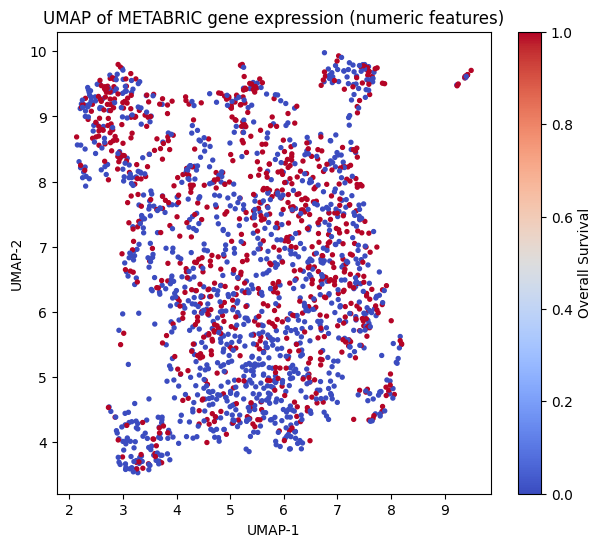

In [17]:
# ----------------------------------------
# UMAP dimensionality reduction
# Project high-dimensional gene expression data to 2D for visualization
# ----------------------------------------
import umap.umap_ as umap
import matplotlib.pyplot as plt

embedding = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    random_state=42
).fit_transform(X_genes_scaled)

plt.figure(figsize=(7,6))
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=clinical["overall_survival"],
    cmap="coolwarm",
    s=8
)
plt.colorbar(label="Overall Survival")
plt.title("UMAP of METABRIC gene expression (numeric features)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.show()


In [19]:
# ----------------------------------------
# Survival analysis using Cox Proportional Hazards
# ----------------------------------------
from lifelines import CoxPHFitter
# Use first 20 genes for demonstration
survival_df = pd.concat(
    [
        clinical[["overall_survival", "overall_survival_months"]],
        gene_expression.iloc[:, :20]  # فقط 20 ژن اول برای سادگی
    ],
    axis=1
)

cph = CoxPHFitter()
cph.fit(
    survival_df,
    duration_col="overall_survival_months", # Time to event
    event_col="overall_survival"# Event indicator
)
# Display summary of Cox model
cph.print_summary()


<lifelines.CoxPHFitter: fitted with 1889 total observations, 1095 right-censored observations>
             duration col = 'overall_survival_months'
                event col = 'overall_survival'
      baseline estimation = breslow
   number of observations = 1889
number of events observed = 794
   partial log-likelihood = -4822.64
         time fit was run = 2025-12-17 18:06:00 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
brca1     -0.09      0.91      0.04           -0.17           -0.01                0.84                0.99
brca2     -0.00      1.00      0.04           -0.08            0.07                0.92                1.08
palb2     -0.02      0.98      0.04           -0.10            0.06                0.90                1.06
pten      -0.04      0.96      0.04           -0.12            0.04                0.88                1.04
tp53       0.14      1.15      0.04            0.07            0.22                1.07                1.24
atm        0.01      1.01      0.04           -0.07            0.08                0.94                1.08
cdh1      -0.03      0.97      0.04           -0.11            0.05                0.89                1.05
chek2      0.13      1.14      0.04            0.05            0.21                1.05                1.23
nbn        0.09      1.10      0.04            0.02            0.17                1.02                1.18
nf1       -0.09      0.92      0.04           -0.17           -0.00                0.84                1.00
stk11     -0.08      0.92      0.04           -0.16            0.00                0.85                1.00
bard1     -0.11      0.90      0.04           -0.20           -0.02                0.82                0.98
mlh1       0.21      1.23      0.04            0.13            0.30                1.13                1.34
msh2      -0.03      0.97      0.06           -0.14            0.08                0.87                1.09
msh6      -0.06      0.94      0.05           -0.15            0.04                0.86                1.04
pms2       0.01      1.01      0.04           -0.07            0.10                0.93                1.10
epcam      0.11      1.11      0.06           -0.00            0.22                1.00                1.24
rad51c     0.04      1.04      0.04           -0.04            0.13                0.96                1.14
rad51d     0.00      1.00      0.04           -0.09            0.09                0.92                1.09
rad50      0.02      1.02      0.04           -0.05            0.09                0.95                1.10

           cmp to     z      p  -log2(p)
covariate                               
brca1        0.00 -2.21   0.03      5.19
brca2        0.00 -0.06   0.95      0.07
palb2        0.00 -0.54   0.59      0.76
pten         0.00 -1.07   0.28      1.81
tp53         0.00  3.72 <0.005     12.29
atm          0.00  0.15   0.88      0.18
cdh1         0.00 -0.74   0.46      1.13
chek2        0.00  3.16 <0.005      9.30
nbn          0.00  2.55   0.01      6.53
nf1          0.00 -2.02   0.04      4.54
stk11        0.00 -1.92   0.05      4.19
bard1        0.00 -2.50   0.01      6.34
mlh1         0.00  4.86 <0.005     19.67
msh2         0.00 -0.50   0.62      0.69
msh6         0.00 -1.22   0.22      2.17
pms2         0.00  0.34   0.73      0.44
epcam        0.00  1.95   0.05      4.28
rad51c       0.00  0.98   0.33      1.61
rad51d       0.00  0.01   0.99      0.01
rad50        0.00  0.56   0.57      0.80
---
Concordance = 0.62
Partial AIC = 9685.29
log-likelihood ratio test = 133.70 on 20 df
-log2(p) of ll-ratio test = 60.15

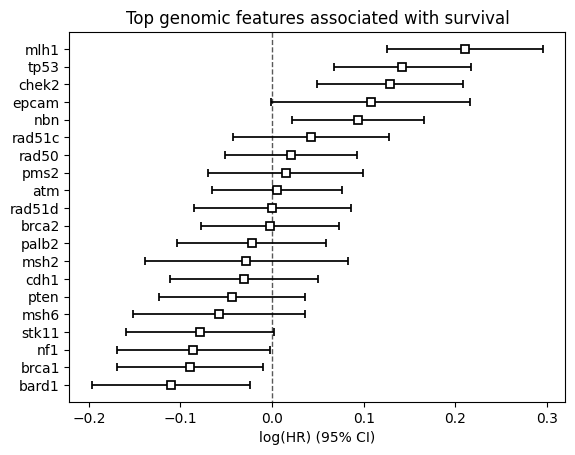

In [20]:
# Plot top genomic features associated with survival
cph.plot()
plt.title("Top genomic features associated with survival")
plt.show()
